# **RL4AA'25 Challenge Part 2:** Open (e.g. controller)

In this notebook you can solve the RL challenge by not using RL but by choosing any kind of algorithm you like, e.g. a controller, a planner or a heuristic. For example, this notebook is the option you want to choose if you want to solve the challenge using a classical control algorithm.

Below you will find a config dictionary, as well as an evaluation function that runs the `gymnasium` environment loop. The latter has a line in it, where an action (i.e. future magnet settings) is computed from a given observation (i.e. current magnet settings, current beam parameter readings and desired beam parameter values). This is the line you should modify to implement your algorithm. In addition, you can modify the config dictionary.

**NOTE:** Please only modify the designated code sections.


In [1]:
import numpy as np
from gymnasium.wrappers import TimeLimit

from src.environments import ea
from src.eval import Study
from src.eval.eval_rl_v3_sim import generate_trials
from src.trial import Trial
from src.wrappers import RecordEpisode

You may change the values in the following `config` dictionary to your liking. Further, you may change **ONLY** the designated line in the cell below that. Most of your solutions will map `observation` to `action`, but you are allowed to do fancier things like keeping track of the history of observations and actions.

`action` should be a NumPy array 5 magnet settings. `observation` is a dictionary with the following keys

- `magnets` : a NumPy array of 5 magnet settings in downstream order
- `beam` : a NumPy array of 4 beam parameters (x position, x size, y position, y size)
- `target` : a NumPy array of 4 target beam parameters (x position, x size, y position, y size)


In [ ]:
# You may change this config to your liking
config = {
    # Setting for incoming beam parameters on reset. Can be `"random"` to generate
    # random parameters or an array of 11 values to set them to a constant value.
    "magnet_init_mode": np.array([10.0, -10.0, 0.0, 10.0, 0.0]),
    # Maximum allowed quadrupole setting. The real quadrupoles can be set from -72 to
    # 72. These limits are imposed by the power supplies, but are unreasonably high to
    # the task at hand. It might therefore make sense to choose a lower value.
    "max_quad_setting": 30,
}

In [ ]:
def evaluate_optimizer(
    config: dict,
    write_data: bool = True,
    seed: int | None = None,
    evaluation_name: str = "unnamed",
) -> None:
    """
    Evaluate an optimiser on a set of trials (different incoming beams, quadrupole
    misalignments and screen misalignments).

    :param config: The configuration dictionary.
    :param write_data: Whether to write the episode data to disk.
    :param seed: The seed to use for generating the trials.
    """

    trials = generate_trials(num=20, seed=seed)

    for i, trial in enumerate(trials):
        evaluate_on_trial(i, trial, config, write_data, evaluation_name)


def evaluate_on_trial(
    trial_index: int,
    trial: Trial,
    config: dict,
    write_data: bool = True,
    evaluation_name: str = "unnamed",
) -> None:
    """
    Evaluate an optimser on a single trial.

    :param trial_index: The index of the trial.
    :param trial: The trial to evaluate on.
    :param model: The policy model to evaluate.
    :param config: The configuration dictionary.
    :param write_data: Whether to write the episode data to disk.
    :param evaluation_name: The name of the evaluation. Used as the directory name
        for the evaluation data.
    """

    # Create the environment
    env = ea.TransverseTuning(
        backend="cheetah",
        backend_args={
            "incoming_mode": trial.incoming_beam,
            "max_misalignment": 5e-4,
            "misalignment_mode": trial.misalignments,
            "simulate_finite_screen": False,
        },
        action_mode="direct",
        magnet_init_mode=config["magnet_init_mode"],
        max_quad_setting=config["max_quad_setting"],
        target_beam_mode=np.zeros(4),
        target_threshold=None,
        threshold_hold=5,
        clip_magnets=True,
    )
    env = TimeLimit(env, 150)
    if write_data:
        env = RecordEpisode(
            env,
            save_dir=(f"data/{evaluation_name}/problem_{trial_index:03d}"),
        )

    # Actual optimisation
    observation, info = env.reset()
    done = False
    # vvvvvvvvvvvv You may add initialisation code here vvvvvvvvvvvv
    ...
    # ^^^^^^^^^^^^ You may add initialisation code here ^^^^^^^^^^^^
    while not done:
        # vvvvvvvvvvvv Only modify the code below vvvvvvvvvvvv

        action = observation["magnets"]  # <<<<<<< Implement your controller logic here
        # The action should be a 5-dimensional np.array

        # ^^^^^^^^^^^^ Only modify the code above ^^^^^^^^^^^^

        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

    env.close()

## Evaluate your implementation

The following code evaluates your implementation. We recommend you give it a useful name. If you fail to do so, some of your old results may be overwritten.


In [4]:
evaluation_name = "just_keep_the_settings"

evaluate_optimizer(
    config=config,
    write_data=True,
    seed=42,
    evaluation_name=evaluation_name,
)

Now the results are loaded, shown to you and a CSV file is generated at `data/csvs/[evaluation_name].csv`. This file is the one you need to submit to the challenge.


In [5]:
study = Study.load(f"data/{evaluation_name}", name=evaluation_name)

In [6]:
study.evaluate_challenge()

Final MAE: 512 μm
Steps to convergence: 1.0
Sum of magnet changes: 0.00


You can also admire your implementation in action by running the following code:


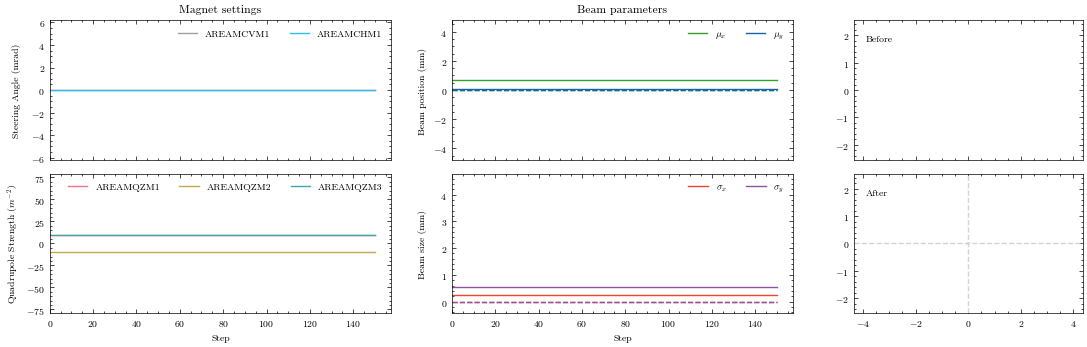

In [7]:
_ = study.episodes[2].plot_summary()

## 🏆 Upload your results to Kaggle

For the chance to win the challenge prize. Go to `data/csvs/` and upload the CSV file via \_"Submit Prediction" to the challenge submission page: https://www.kaggle.com/t/ad56a627d147405fa7b5c8629c8b7cf4
